# Project translation

In [2]:
import scipy as sp
import scipy.interpolate
import scipy.optimize


from numpy.fft import fft, ifft, fft2, ifft2
import numpy as np 

import matplotlib.pyplot as plt

import imageio as im

## Cross product method: Pixel to pixel

The function "cross" calculates the cross product between the 2D function a and b and returns the coordinates
of the maximum express in number of pixel.
The cross product between two images a and b is given by the following formula:

$C_{tx,ty}=\sum_{i=1,j=1}^{N} a_{i,j} b_{i+tx,j+ty} dx $

where tx and ty are the translation parameter.

Supposing that a and b are just the same image but with some translation we would find the maximum of the cross product when the two images are superimposed one over the other and for that reason the tx and ty in that case would be exactly the amount of translation between the two images.
For computational reason it is more convenient to move to the Fourier space. In fact the cross product is equivalent to the product of the Fourier transform of a and b. The only attention to be made is that in constrast with the convolution product this time we need to take conjiugate of the image a.

$ a \otimes b= \mathfrak{F}(a)^* \mathfrak{F}(b)$

The function "cross" maximize the FFT product anf for this reason this translation problem beacomes a maximization problem.
For this reason we expect come porblems with noisy images.

In [11]:
def cross (a,b,show=False):
    
    
    F2Da=np.conj(np.fft.fft2(a))                                    
    F2Db=(np.fft.fft2(b))
    cross=np.abs(np.fft.fftshift(np.fft.ifft2(F2Da*F2Db)))     #calculate the product of the two fourier transform and reorder the vector trough np.fftshift 
    
    if show:
        plt.imshow(cross)
        plt.title('Cross Product')

    traslation=np.array(2)
    traslation=np.array(np.unravel_index(np.argmax(cross, axis=None), cross.shape))
    max_coordinate=[traslation[1]-a.shape[1]/2,traslation[0]-a.shape[0]/2]
    
    return max_coordinate

In [12]:
#DEFINING A FUNCTION RETURNING A 2D-GAUSSIAN



def gaussian2(amp,dpix,mu_x,mu_y,sigma_x,sigma_y,norm=False,show=False):

    x=np.arange(-amp,amp,dpix)
    y=np.arange(-amp,amp,dpix)
    
    gauss2d=np.array([[np.exp(-((i-mu_x)**2)/(2*(sigma_x**2)))*np.exp(-((j-mu_y)**2)/(2*(sigma_y**2))) for i in x]for j in y])

    if norm:
        gauss2d=(1/(sigma_x*((2*np.pi)**0.5)))*(1/(sigma_y*((2*np.pi)**0.5)))*gauss2d 
                 
    if show:
        gauss2d=np.array(gauss2d)
        plt.figure(figsize=(10,10))
        plt.imshow(gauss2d)
        #nel label viene messo l'indice di matrice
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("2D Gaussian")
        posizionePicco=np.array(np.unravel_index(np.argmax(gauss2d, axis=None),gauss2d.shape))
        posizionePicco=posizionePicco*dpix-[int(x[-1])+1,int(y[-1])+1]
        print('peak:',posizionePicco)
                 
    return gauss2d

In [13]:
#DEFINING A FUNCTION RETURNING A 2D-SINUSOID

def sin2(amp,dpix,f_x,f_y,t_x,t_y,show=False):

    x=np.arange(-amp,amp,dpix)
    y=np.arange(-amp,amp,dpix)
    K=2*np.pi
    
    sin2d=np.array([[(np.sin(K*(f_x*(i-t_x)+f_y*(j-t_y)))) for i in x]for j in y])
                 
    if show:
        sin2d=np.array(sin2d)
        plt.figure(figsize=(10,10))
        plt.imshow(sin2d)
        #nel label viene messo l'indice di matrice
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("2D Sinusoid")
                 
    return sin2d

Now we try the algorithm with two gaussian  one translated of a value tx and ty.
Since the the gaussian has a clear peak we expect that in this case without any perturbation it will work very well.
In addition to that we highlight that tha FFT of a gaussian is still a gaussian and a product between two gaussian is still a gaussian. Due to that we expect that the cross product is still a gaussian.



[-30.0, 10.0]

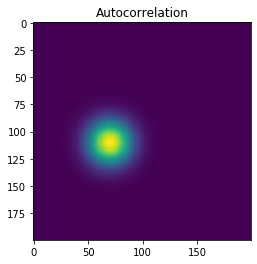

In [15]:
amp=10       ###dimension of the gaussian
dpix=0.1     ### dimension of the pixel
sigma_x=1
sigma_y=1
##the translation parameter are given in unit and not pixel 
##to obtain the traslation in pixel it is sufficient to divide for dpix
tx=-3       
ty=1

g_centered=gaussian2(amp,dpix,0,0,sigma_x,sigma_y)
g_t=gaussian2(amp,dpix,tx,ty,sigma_x,sigma_y)        #translated gaussian

cross(g_centered,g_t,show=True)


As we can see the image shown is still a gaussian and the translation is the expected value.

Now we evaluate the algorithm with a noisy image.
In particular we add some white noise (obtained by a random matrice) to the two gaussian.
it is noticeable that the amplitude of te picks of the gaussians are 1 in the way we build them.
Since it is a maximization problem we expect that the addicition odf noise it will eventually lead to error in the solution.
For this reason we did an analysis on the obtained results.
If the noise has also the same amplitude the results are the following

In [34]:
                         ##amplitude of the noise
trials=2000                         ##number of trial with different noise
results1=np.zeros((2,trials))
results2=np.zeros((2,trials))

g_centered=gaussian2(amp,dpix,0,0,sigma_x,sigma_y)
g_t=gaussian2(amp,dpix,tx,ty,sigma_x,sigma_y)

## we do a sequence of trial and we obtain the distribution of the error made by adding noise
height=1   
for i in range (0,trials):
    rumore1=np.random.rand(int(2*amp/dpix),int(2*amp/dpix))
    rumore2=np.random.rand(int(2*amp/dpix),int(2*amp/dpix))
    g_centered_n=g_centered+height*rumore1
    g_t_n=g_t+height*rumore2
    results1[:,i]=cross(g_centered_n,g_t_n)
height=2    
for i in range (0,trials):
    rumore1=np.random.rand(int(2*amp/dpix),int(2*amp/dpix))
    rumore2=np.random.rand(int(2*amp/dpix),int(2*amp/dpix))
    g_centered_n=g_centered+height*rumore1
    g_t_n=g_t+height*rumore2
    results2[:,i]=cross(g_centered_n,g_t_n)
        

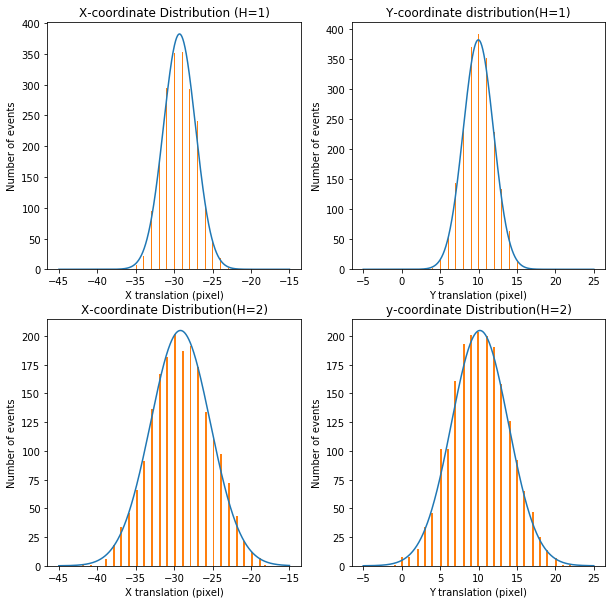

In [41]:
plt.figure(figsize=(10,10))    
plt.tight_layout()

plt.subplot(221)
plt.title("X-coordinate Distribution (H=1)")
plt.xlabel("X translation (pixel)")
plt.ylabel("Number of events")
sigma_x=np.std(results1[0,:])
mu_x=np.mean(results1[0,:])
x_g=np.linspace(tx/dpix-15,tx/dpix+15,1000)
y_g=trials*(1/(sigma_x*((2*np.pi)**0.5)))*np.array([np.exp(-((j-mu_x)**2)/(2*(sigma_x**2))) for j in x_g])
plt.plot(x_g,y_g)
plt.hist(results1[0,:],bins=100);


plt.subplot(222)
plt.title("Y-coordinate distribution(H=1)")
plt.xlabel("Y translation (pixel)")
plt.ylabel("Number of events")
sigma_y=np.std(results1[1,:])
mu_y=np.mean(results1[1,:])
x=np.linspace(ty/dpix-15,ty/dpix+15,1000)
y=trials*(1/(sigma_x*((2*np.pi)**0.5)))*np.array([np.exp(-((i-mu_y)**2)/(2*(sigma_y**2))) for i in x])
plt.plot(x,y)
plt.hist(results1[1,:],bins=100);

plt.subplot(223)
plt.title("X-coordinate Distribution(H=2)")
plt.xlabel("X translation (pixel)")
plt.ylabel("Number of events")
sigma_x=np.std(results2[0,:])
mu_x=np.mean(results2[0,:])
x_g=np.linspace(tx/dpix-15,tx/dpix+15,1000)
y_g=trials*(1/(sigma_x*((2*np.pi)**0.5)))*np.array([np.exp(-((j-mu_x)**2)/(2*(sigma_x**2))) for j in x_g])
plt.plot(x_g,y_g)
plt.hist(results2[0,:],bins=100);

plt.subplot(224)
plt.title("y-coordinate Distribution(H=2)")
plt.xlabel("Y translation (pixel)")
plt.ylabel("Number of events")
sigma_y=np.std(results2[1,:])
mu_y=np.mean(results2[1,:])
x=np.linspace(ty/dpix-15,ty/dpix+15,1000)
y=trials*(1/(sigma_x*((2*np.pi)**0.5)))*np.array([np.exp(-((i-mu_y)**2)/(2*(sigma_y**2))) for i in x])
plt.plot(x,y)
plt.hist(results2[1,:],bins=100);

We want to try the algorithm  to a real case that we encountered in another course and specifically to an image of the surface of a graphite sample taken by us in the lab this year.
The two images are real images taken by the same instrument in two different ways and their reciprocal translation represents the quality of the probe microscope.
This images are periodic due to the structure of graphite and for that reason the function could have some difficulties.

With this analysis we established that the error increases with the amplitude of noise with a linear or sublinear trend, knowing that doubling the amplitude of error induce almost a doubling of the standard deviation.


Since now the test have been made on a gaussian that has one clear peak but we need to evaluate it over a periodical image.
Due to the fact that the cross product of a peridocal image is a periodical image itself this leads to the problem that there is no more a unique maximum but numerous maxima that can lead to a false interpretation of the translation parameter.
We applied the function to a sinus plane to see the results.


[-95.0, -100.0]

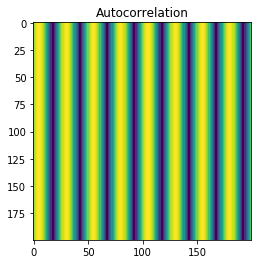

In [0]:
amp=10
dpix=0.1
fx=-0.2
fy=0
tx=3
ty=0
s_centered=sin2(amp,dpix,fx,fy,0,0)
s_t=sin2(amp,dpix,fx,fy,tx,ty)
cross(s_centered,s_t,show=True)

As expected the function was not able to recognise the right translation due to the presence of numerous maxima but gives a much bigger result.

We now try this algorithm based on correlation to evaluate the translation of same real images. From the previous results we expect that this algorith works better for the non periodic images, for which the autocorrelation has a very distinguishable maximum. As we told before the presence of more than one maximum in the correlation is one of the bigger limitations of this algorithm. We also try to use this algorith with rotated and tilted images to explore its other limitations.

[0.0, 0.0]

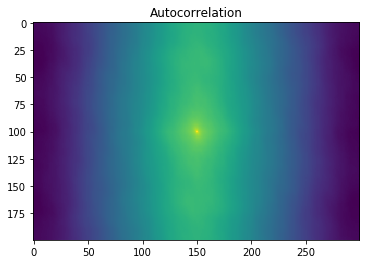

In [0]:
pic=im.imread('glassbw.png')
pic.shape

cross(pic,pic,show=True)

[0.0, 0.0]

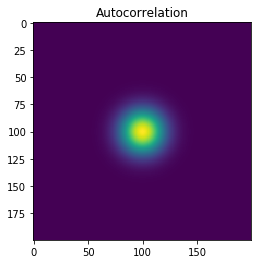

In [0]:
tx=-3
ty=2
g_t2=gaussian2(amp,dpix,tx,ty,sigma_x,sigma_y)
cross(g_t,g_t,show=True)

# Covariance by subpixel translation


In [0]:
def func(x, y, t):
    mu_x=0
    mu_y=0
    sigma_x=1
    sigma_y=1
    
    return np.exp(-((x+t-mu_x)**2)/(2*(sigma_x**2)))*np.exp(-((y-mu_y)**2)/(2*(sigma_y**2)))

In [0]:
dpix=0.2
amp=1
t=0.2

#grid
grid_x, grid_y = np.mgrid[-0.5+t:0.5+t:1000j, -0.5:0.5:1000j]

#points
xy=np.arange(-amp,amp,dpix)
xy=np.append(xy,amp)
points=np.zeros(((len(xy))**2+1,2))
for n in range (0,len(xy)):
    for m in range (0,len(xy)):
        points[len(xy)*n+m,0]=xy[n]
        points[len(xy)*n+m,1]=xy[m]
        


#values
values = func(points[:,0], points[:,1],0)

In [0]:
grid_z0 = sp.interpolate.griddata(points, values, (grid_x, grid_y), method='nearest')
grid_z1 = sp.interpolate.griddata(points, values,(grid_x, grid_y), method='linear')
grid_z2 = sp.interpolate.griddata(points, values, (grid_x, grid_y), method='cubic')

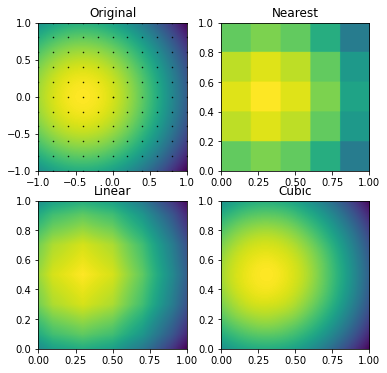

In [0]:
plt.subplot(221)
plt.imshow(func(grid_x, grid_y,0).T, extent=(-1,1,-1,1), origin='lower')
plt.plot(points[:,0], points[:,1], 'k.', ms=1)
plt.title('Original')
plt.subplot(222)
plt.imshow(grid_z0.T, extent=(0,1,0,1), origin='lower')

plt.title('Nearest')
plt.subplot(223)
plt.imshow(grid_z1.T, extent=(0,1,0,1), origin='lower')
plt.title('Linear')
plt.subplot(224)
plt.imshow(grid_z2.T, extent=(0,1,0,1), origin='lower')
plt.title('Cubic')
plt.gcf().set_size_inches(6, 6)
plt.show()

Text(0.5, 1.0, 'Error Cubic')

<Figure size 1080x1080 with 0 Axes>

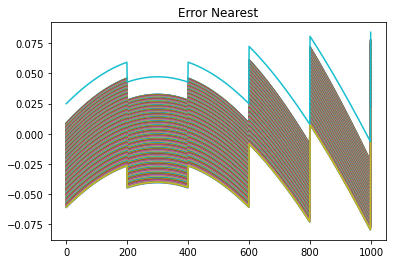

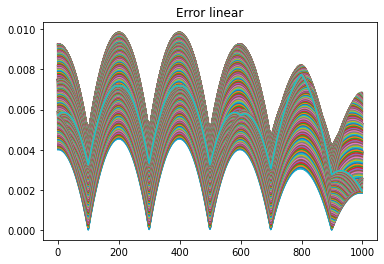

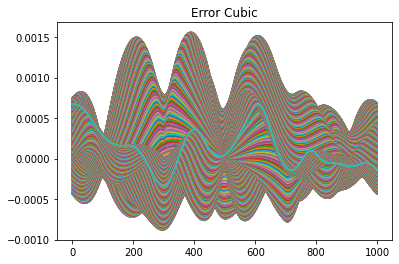

In [0]:
plt.figure(figsize=(15,15))
plt.figure(311)
err0=func(grid_x, grid_y,0)-grid_z0
plt.plot(err0)
plt.title('Error Nearest')

plt.figure(312)
err1=func(grid_x, grid_y,0)-grid_z1
plt.plot(err1)
plt.title('Error linear')

plt.figure(313)
err2=func(grid_x, grid_y,0)-grid_z2
plt.plot(err2)
plt.title('Error Cubic')


In [9]:
a=gaussian2(amp,dpix,0,0,sigma_x,sigma_y)
b=gaussian2(amp,dpix,0.057,0,sigma_x,sigma_y)

def norm2(t):
            
        lenx=a.shape[1]
        leny=a.shape[0]
               
        grida_x, grida_y = np.mgrid[20:lenx-20:100j, 20:leny-20:100j]
        gridb_x, gridb_y = np.mgrid[20+t[0]:lenx-20+t[0]:100j,20+t[1]:leny-20+t[1]:100j]

                          #points
        dx=np.arange(0,lenx,1)
        dy=np.arange(0,leny,1)
        x,y = np.meshgrid(dx, dy)
        points = x.flatten(), y.flatten()
        values_a=a.flatten()
        values_b=b.flatten()
        a_grid= sp.interpolate.griddata(points, values_a,(grida_x, grida_y), method='cubic')
        b_grid= sp.interpolate.griddata(points, values_b,(gridb_x, gridb_y), method='cubic')

        norm=np.linalg.norm((a_grid-b_grid)[~np.isnan(a_grid-b_grid)])        
        norm
        return norm

In [10]:
start=0*np.ones(2)
norm2(start)
res=sp.optimize.minimize(norm2,start,method='BFGS')
res

      fun: 0.0016279086941131434
 hess_inv: array([[ 0.00272675, -0.00012616],
       [-0.00012616,  0.00364252]])
      jac: array([-4.73321415e-06, -9.80592449e-06])
  message: 'Optimization terminated successfully.'
     nfev: 72
      nit: 7
     njev: 18
   status: 0
  success: True
        x: array([5.69944393e-01, 8.23720748e-05])

It is interesting to note that in constrast with the perfect periodic image we tried before in this case the algorithm actually worked. The reason can be found in the fact that real images are almost never perfectly periodic but in some sense there are always some defects or aperiodicity. This feature implies that there is an absolute maximum in spite of the presence of many maxima that due to the defects of the image are smaller.
This is in constrast with the sinus images where there were lot of maxima of the same ampltude and this gave rise to problem in the identification of translation parameter.
Surely a periodic image is however very sensible to noise given the presence of the other maxima.

The results of this simulation shows that it is needed a little bit of noise to start to make divergeing the results of the algorithm as we expected since the cross correlation displays a peak in a zone where the values don't change that much.
This made this type of image ( with a big portion of monocromatic backgorund) really sensible to noise.